In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd

# If your notebook is in model/notebooks
REPO_ROOT = Path.cwd().parent.parent
BACKEND_DIR = REPO_ROOT / "backend"
sys.path.insert(0, str(BACKEND_DIR))

from data_engine.yfinance_fetcher import YFinanceFetcher

In [2]:
fetcher = YFinanceFetcher()

SYMBOL = "BTC-USD"
INTERVAL = "1wk"
PERIOD = "5y"

df = fetcher.fetch_history(SYMBOL, interval=INTERVAL, period=PERIOD)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)

prices = df.set_index("timestamp")["close"].astype(float).dropna()
len(prices), prices.head()

(261,
 timestamp
 2021-02-22 00:00:00+00:00    45137.769531
 2021-03-01 00:00:00+00:00    51206.691406
 2021-03-08 00:00:00+00:00    59302.316406
 2021-03-15 00:00:00+00:00    57523.421875
 2021-03-22 00:00:00+00:00    55950.746094
 Name: close, dtype: float64)

In [3]:
LOOKBACK = 20  # same concept as LSTM lookback

tmp = pd.DataFrame({"y": prices})
for i in range(1, LOOKBACK + 1):
    tmp[f"lag_{i}"] = tmp["y"].shift(i)

# Target: next week's price (1-step ahead)
tmp["y_next"] = tmp["y"].shift(-1)

model_df = tmp.dropna().copy()
feature_cols = [c for c in model_df.columns if c.startswith("lag_")]

model_df.head(), model_df.shape

(                                      y         lag_1         lag_2  \
 timestamp                                                             
 2021-07-12 00:00:00+00:00  31796.810547  34240.187500  35287.781250   
 2021-07-19 00:00:00+00:00  35350.187500  31796.810547  34240.187500   
 2021-07-26 00:00:00+00:00  39974.894531  35350.187500  31796.810547   
 2021-08-02 00:00:00+00:00  43798.117188  39974.894531  35350.187500   
 2021-08-09 00:00:00+00:00  47047.003906  43798.117188  39974.894531   
 
                                   lag_3         lag_4         lag_5  \
 timestamp                                                             
 2021-07-12 00:00:00+00:00  34649.644531  35698.296875  39097.859375   
 2021-07-19 00:00:00+00:00  35287.781250  34649.644531  35698.296875   
 2021-07-26 00:00:00+00:00  34240.187500  35287.781250  34649.644531   
 2021-08-02 00:00:00+00:00  31796.810547  34240.187500  35287.781250   
 2021-08-09 00:00:00+00:00  35350.187500  31796.810547  34240.

In [4]:
from xgboost import XGBRegressor
from math import sqrt

TEST_SIZE = 30

def walk_forward_xgb(df, feature_cols, target_col, test_size, params):
    preds = []
    split = len(df) - test_size

    for i in range(split, len(df)):
        train = df.iloc[:i]
        test_row = df.iloc[i:i+1]

        X_train = train[feature_cols]
        y_train = train[target_col]
        X_test = test_row[feature_cols]

        model = XGBRegressor(**params)
        model.fit(X_train, y_train)

        y_true = float(test_row[target_col].iloc[0])
        y_pred = float(model.predict(X_test)[0])

        preds.append({"timestamp": test_row.index[0], "y_true": y_true, "y_pred": y_pred})

    return pd.DataFrame(preds).set_index("timestamp")

def metrics(df_pred):
    y = df_pred["y_true"].to_numpy()
    yhat = df_pred["y_pred"].to_numpy()
    mae = np.mean(np.abs(y - yhat))
    rmse = sqrt(np.mean((y - yhat)**2))
    mape = np.mean(np.abs((y - yhat) / y)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE_%": mape}

params = dict(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    objective="reg:squarederror",
)

xgb_pred = walk_forward_xgb(model_df, feature_cols, "y_next", TEST_SIZE, params)
metrics(xgb_pred), xgb_pred.head()

({'MAE': np.float64(7185.950520833333),
  'RMSE': 9535.543771355773,
  'MAPE_%': np.float64(7.590444404299017)},
                                   y_true         y_pred
 timestamp                                              
 2025-07-21 00:00:00+00:00  114217.671875   99891.140625
 2025-07-28 00:00:00+00:00  119306.757812   94867.312500
 2025-08-04 00:00:00+00:00  117453.062500  105217.375000
 2025-08-11 00:00:00+00:00  113458.429688  115323.945312
 2025-08-18 00:00:00+00:00  108236.710938  108201.523438)

In [5]:
xgb_metrics = metrics(xgb_pred)
print("XGBoost (lags-only) metrics:")
for k, v in xgb_metrics.items():
    print(f"  {k}: {v:,.4f}")

XGBoost (lags-only) metrics:
  MAE: 7,185.9505
  RMSE: 9,535.5438
  MAPE_%: 7.5904


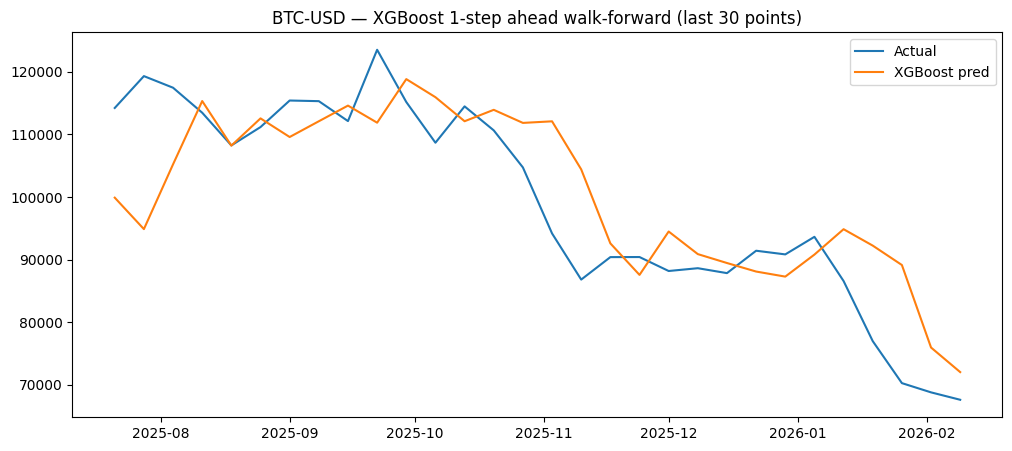

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(xgb_pred.index, xgb_pred["y_true"], label="Actual")
plt.plot(xgb_pred.index, xgb_pred["y_pred"], label="XGBoost pred")
plt.title(f"{SYMBOL} — XGBoost 1-step ahead walk-forward (last {TEST_SIZE} points)")
plt.legend()
plt.show()

In [7]:
from math import sqrt

def backtest_one_step(prices_full: pd.Series, test_size: int, model_factory, min_train: int):
    """
    Walk-forward 1-step backtest with expanding window.
    
    model_factory: callable that returns a NEW model instance each iteration
    min_train: minimum samples required before first forecast
    """
    preds = []
    
    split_idx = len(prices_full) - test_size
    for i in range(split_idx, len(prices_full)):
        train = prices_full.iloc[:i]
        actual = float(prices_full.iloc[i])
        ts = prices_full.index[i]
        
        if len(train) < min_train:
            continue
        
        model = model_factory()
        model.fit(train)
        fc = model.forecast(periods=1)
        yhat = float(fc["point_forecast"][0])
        
        preds.append({"timestamp": ts, "y_true": actual, "y_pred": yhat})
    
    out = pd.DataFrame(preds).set_index("timestamp")
    return out

Baseline metrics: {'MAE': np.float64(11022.10061875), 'RMSE': 13084.91647502141, 'MAPE_%': np.float64(12.449416610946637)}
XGBoost metrics: {'MAE': np.float64(7185.950520833333), 'RMSE': 9535.543771355773, 'MAPE_%': np.float64(7.590444404299017)}


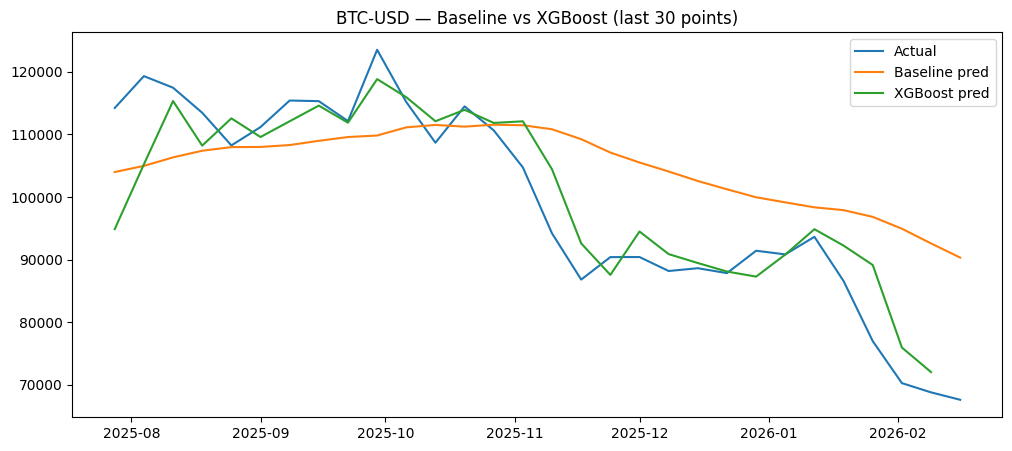

In [8]:
from data_engine.forecasting.base_forecaster import SimpleForecaster

BASELINE_SPAN = 20

baseline_pred = backtest_one_step(
    prices_full=prices,
    test_size=TEST_SIZE,
    model_factory=lambda: SimpleForecaster(span=BASELINE_SPAN, confidence_level=0.95),
    min_train=BASELINE_SPAN
)

print("Baseline metrics:", metrics(baseline_pred))
print("XGBoost metrics:", metrics(xgb_pred))

plot_df = baseline_pred.join(xgb_pred, lsuffix="_base", rsuffix="_xgb")

plt.figure(figsize=(12,5))
plt.plot(plot_df.index, plot_df["y_true_base"], label="Actual")
plt.plot(plot_df.index, plot_df["y_pred_base"], label="Baseline pred")
plt.plot(plot_df.index, plot_df["y_pred_xgb"], label="XGBoost pred")
plt.title(f"{SYMBOL} — Baseline vs XGBoost (last {TEST_SIZE} points)")
plt.legend()
plt.show()

In [9]:
# %pip install pyarrow

In [10]:
OUTDIR = REPO_ROOT / "model" / "notebooks" / "artifacts"
OUTDIR.mkdir(parents=True, exist_ok=True)

xgb_path = OUTDIR / "pred_xgb_weekly_price.parquet"
xgb_pred.reset_index().to_parquet(xgb_path, index=False)
print("Saved:", xgb_path)

Saved: c:\Users\khanh\OneDrive - GUSCanada\Documents\capstone_project_unfc\model\notebooks\artifacts\pred_xgb_weekly_price.parquet


In [12]:
compare = pd.DataFrame([
    {"Model": "Baseline (EWM SimpleForecaster)", **metrics(baseline_pred)},
    {"Model": "XGBoost", **metrics(xgb_pred)},
]).set_index("Model")

compare

,MAE,RMSE,MAPE_%
Model,,,
Baseline (EWM SimpleForecaster),11022.100619,13084.916475,12.449417
XGBoost,7185.950521,9535.543771,7.590444
